In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip

import psycopg2

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")
EMBEDDINGS_FOLDER = PARENT + os.getenv("EMBEDDINGS_FOLDER")
MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
DB_INPUT_SUBJECTMATTER = PARENT + os.getenv("DB_INPUT_SUBJECTMATTER")

def get_db_config():
    return {
        "host": os.getenv("DB_HOST"),
        "port": os.getenv("DB_PORT"),
        "name": os.getenv("DB_NAME"),
        "user": os.getenv("DB_USER"),
        "password": os.getenv("DB_PASSWORD"),
    }

##

def fixPath(path):
    return path.replace(".././", "../")

In [8]:
# Query the DB for all the recordIDs of the table Artwork
def get_image_data_from_db(db_config):
    conn = None
    try:
        conn = psycopg2.connect(
            host=db_config["host"],
            port=db_config["port"],
            database=db_config["name"],
            user=db_config["user"],
            password=db_config["password"]
        )
        cur = conn.cursor()
        cur.execute(f"SELECT recordID, imageLowResFilename FROM Artwork")
        data = cur.fetchall()
        cur.close()
        return data
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

DATA = get_image_data_from_db(get_db_config())
DATA[:5]

[(64, '/art-foto/old/internet/Bouts-8181dig-L.jpg'),
 (77, '/art-foto/mod/Internet/deSmet-11120dig-L.jpg'),
 (78, '/art-foto/mod/Internet/Khnopff-3980dig-L.jpg'),
 (79, '/art-foto/mod/Internet/Khnopff-6366dig-L.jpg'),
 (80, '/art-foto/mod/Internet/Khnopff-6768dig-L.jpg')]

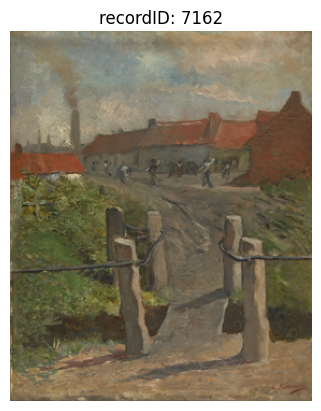

In [15]:
# Show a random image
def getImagePath(image_path):
    return fixPath(os.path.join(IMAGES_FOLDER, image_path[1:]))

recordID, image_path = random.choice(DATA)
image = Image.open(getImagePath(image_path))
plt.imshow(image, cmap="gray")
plt.title(f"recordID: {recordID}")
plt.axis("off")
plt.show()

In [34]:
path_embeddings = PARENT + os.getenv("february_finetuned_path_embeddings")
path_index_to_recordID = PARENT + os.getenv("february_finetuned_path_index_to_recordID")

In [ ]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")
# Load the weights of the model
weights_path = os.path.join(MODELS_FOLDER, "2025-02-05 17_09_07_allFocus_5.pt")
# Load the weights of the model
model.load_state_dict(torch.load(weights_path))

C:\Users\victo\AppData\Local\Temp\ipykernel_25060\2936828758.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

In [24]:
class ComputeEmbeddingsDataset(Dataset):
    def __init__(self, data, getImagePath):
        self.data = data
        self.getImagePath = getImagePath

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        _, image_path = self.data[idx]
        path = self.getImagePath(image_path)
        path = path.replace("internet", "Internet")
        path = path.replace("Mod", "mod")
        path = path.replace("Old", "old")
        path = path.replace("Stefaan", "stefaan")
        path = path.replace("Art-Foto", "art-foto")
        image = Image.open(path)

        return image
    
def customBatchBuilder(images):
    inputs = processor(text=[""] * len(images), images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

dataset = ComputeEmbeddingsDataset(DATA, getImagePath)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=customBatchBuilder)
print(len(dataset), len(dataloader))

5301 5301


In [26]:
path_embeddings

('./../.././private_data/embeddings/february_finetuned/february_finetuned_embeddings.npy',)

In [ ]:
def compute_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            pixel_values = sample['pixel_values'].to(device)

            # Compute image embeddings
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.flatten(1)

            embeddings.append(image_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

embeddings = compute_embeddings(dataloader, model, device)
# Save the embeddings
np.save(path_embeddings, embeddings)
embeddings.shape

100%|██████████| 5301/5301 [02:53<00:00, 30.54it/s]


TypeError: expected str, bytes or os.PathLike object, not tuple

In [35]:
index_to_recordID = {}
for i, (recordID, _) in enumerate(DATA):
    index_to_recordID[i] = recordID

with open(path_index_to_recordID, "w") as f:
    json.dump(index_to_recordID, f)

In [37]:
embeddings = np.load(path_embeddings)
embeddings[0].tobytes()

b'\x8a\xd9I\xbc\x99\xb0\r<M\xe8\x9b\xbc\x08\xf2\x9e<\x9e]\xcb\xbc\x02\xd6S<\x0c\xb6V=*\x9b\x16=\x01\xf95:\x8bp\xe5\xbc\xfd8\xbb;\xfc\xb7\x90\xbc\xcd\xbd\xe5\xbbN\xd4\xca<\xf3P\t\xbdU\x86\x08<\x10,\xda\xbc\xd5\xdf\xd7<\xf2\xb48=\xdb\x1b\x82\xbbi\xf9"=\x0c\xf2w\xbcS\x95E\xbd\xdf\x92\x93\xbc\xe1)\xf2=L~\xca\xbc\x88\x1a\xa9;\xe7\xd0\x8b<l\xe7\xe9\xbc\xe1\xff\x85\xbc\xfe\xb0\x1a\xbd\x8a\xc5\xee\xbc\xe9\x89\x81\xbd\xca\x90\n\xbd\xa4pM<5l6\xbd\xb0\xdcc;S\x02:\xbas\x97\x9f;h2n\xbcUE\xb5\xbc\n$^;\xfb@\x02="u\xa9\xbbw<\xa8<\x0b_1=\xe9\xaa\xc2\xbaT:I\xbd\x92\xa3z;\x0b\x95C<\xcb\x1dg\xbc\xb4d\x15\xbb\xfdf\x1c=\xd5}%\xbd\xc4AT;\xc2\xb7\xec\xbb\xca\x90\x80<@\xc7\x87\xbd\xa1\xeb\xf0\xbc\xa9W|=\xbe\x0e\x1d=F\x838\xbd\x0e\x02j\xbd\x91\xe50\xbd\xbez\x9f\xbcD\xd6\xa7;\x07\xac\\<!\'\x88<r\x14\xd6<\'\xc2\xff\xba\xa5R\n<>\xb3\x18<\x01\x1dT=\x90\xba\x19<\xb0T\xa1\xbc\x93\x0f\xfa<\xa5\xd2`<5a\xea\xbb\x91\x13\x16\xbcu`q;\xdd\xff\x1f\xbc\x8a\x97j<\n\x13\x86\xbc\xada\x00=\xfd\x9e^<\xc9\xea\x84\xbc\x07\xba\xf7<\x